In [1]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path
import shutil

In [2]:
sys.path.append('../utils')

In [3]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter
from focal_tversky_loss import *

In [4]:
train_data = ChannelData(
    path=Path('../data/crop_512x320/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_512x320/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})

# shutil.rmtree("./logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# model.compile_model(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
#     loss=generalized_dice_loss, 
#     metrics=['accuracy']
# )

In [7]:
from tensorflow.keras.callbacks import Callback


class LRFinder(Callback):
    """Callback that exponentially adjusts the learning rate after each training batch between start_lr and
    end_lr for a maximum number of batches: max_step. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the plot method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [8]:
BATCH_SIZE = 2
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.compile_model(
    optimizer='adam', 
    loss=reduced_iou_loss, 
    metrics=['accuracy']
)

lr_finder = LRFinder()
model.unet.fit(
    train_dataset, epochs=2, 
    callbacks=[lr_finder]
)

Epoch 1/2
336/336 [==============================] - 155s 460ms/step - loss: 0.9587 - accuracy: 0.8606


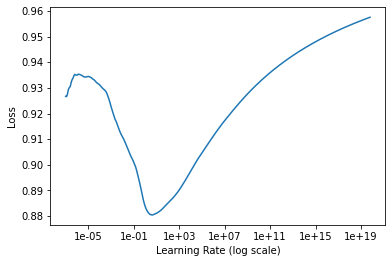

In [9]:
lr_finder.plot()

In [ ]:
BATCH_SIZE = 2
BUFFER_SIZE = 6

initial_learning_rate = 1e-1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.01,
    staircase=True)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=reduced_iou_loss, 
    metrics=['accuracy', tp, tn]
)

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=10, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/10
  1/336 [..............................] - ETA: 0s - loss: 0.9683 - accuracy: 0.6596 - tp: 0.4547 - tn: 0.6628WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
216/336 [==================>...........] - ETA: 56s - loss: 0.6469 - accuracy: 0.9499 - tp: 0.6646 - tn: 0.9583

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


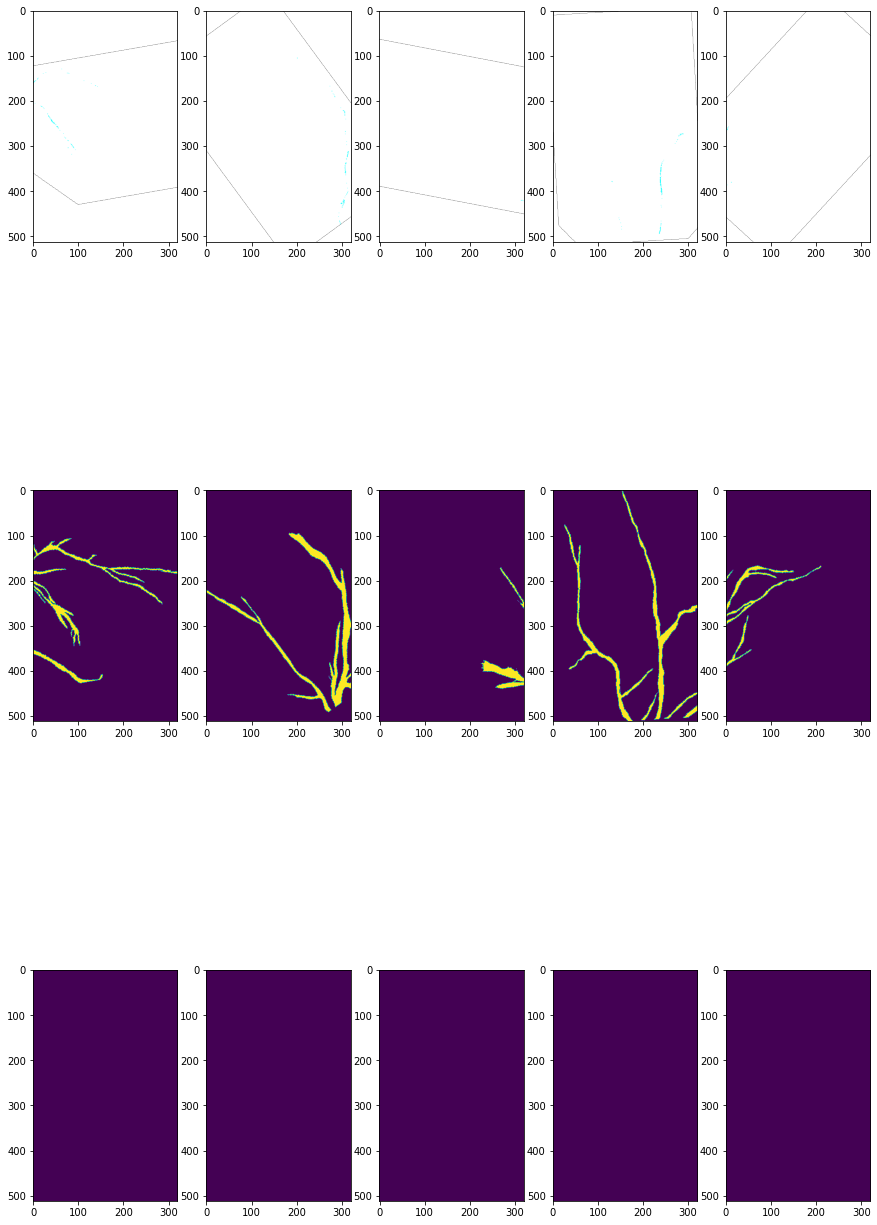

In [10]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(15, n_samples*5))
i = 0
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model.unet.predict(x)[0, :, :, 1])
    i += 1
    
plt.show()

In [11]:
y[0, :, 200, 0]

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0